In [62]:
import numpy as np 
import pandas as pd
import pickle, glob, os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
from collections import defaultdict
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
import warnings

warnings.filterwarnings("ignore")


def to_datetime(date):
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)

In [74]:
place = 'Taoyuan'
year = 2021

stages= 4 if year == 2023 else 3
# file = glob.glob(f'../Results/soundsepration/{place}-5min/*_{year}*{stages}stage_separation/result_normalized_each_stage/{place}_S1_cluster_std_each_stage.csv')[0]

#test 
file = glob.glob(f'./qqq/result*/{place}_S1_cluster_std_each_stage.csv')[0]
print(file)
savepath = file.rsplit('/', 1)[0]
df = pd.read_csv(file)

df_datetime = pd.DataFrame({'Datetime': [datetime.fromtimestamp(t) for t in df['Time'] ]} )
df = pd.concat([df,df_datetime], axis=1)
# df = df[~df['S1_Cluster'].isna()]

./qqq/result_normalized_each_stage/Taoyuan_S1_cluster_std_each_stage.csv


In [75]:
df_ = df.filter(regex='Cluster')
# S1_total, S3_total = [np.max(df_[key]) for key in df_.keys() ]
S1_total = [np.max(df_[key]) for key in df_.keys() ][0]
total_cluster = int(sum([ np.max(df_[key]) for key in df_.keys() ]))
# print(S1_total, S3_total)
print(total_cluster)

9


In [76]:
datelist = []

spec = defaultdict(list)
# spec = {'S1_1':[],
#        'S1_2': [],
#        'S1_3': [],
#        'S1_4': [],
#        'S3_1': [],
#        'S3_2': [],
#        'S3_3': []}

month = df['Datetime'][0].month
day = df['Datetime'][0].day
datezero = datetime(year, month, day, 0, 0, 0)
date = datetime(year, month, day, 23, 59, 0)

for dd in range(365*3):
    for hh in [23]:

        df_temp = df[df['Datetime'] < datetime(date.year, date.month, date.day, hh, 59, 0)][df['Datetime'] >= datetime(date.year, date.month, date.day, 0, 0, 0)]
        if len(df_temp[~df_temp['S1_Cluster'].isna()]) != 0: 

            df_temp_s1 = df_temp['S1_Cluster']

            df_temp_c1 = set(df_temp_s1)

            for cc in range(1, int(S1_total)+1):
                if date.month ==12 and date.day == 24:
                    print(cc, df_temp_s1.to_list().count(cc))
                spec[f'S1_{cc}'].append(df_temp_s1.to_list().count(cc)) 
  
        else:
            for cc in range(1, int(S1_total)+1):
                spec[f'S1_{cc}'].append(np.nan)

        datelist.append(datetime(date.year, date.month, date.day, hh))
    date = date + timedelta(days = 1) 
df_spec = pd.DataFrame(spec)

1 0
2 0
3 0
4 288
5 0
6 0
7 0
8 0
9 0


In [77]:
sumlist = df_spec.sum(min_count=1, axis=1)
dp = pd.DataFrame(np.array([((df_spec.values[i:i+1]).tolist()[0]/ sumlist.values[i]).tolist()  for i in range(len(df_spec))] ))
# p_log = dp*np.log10(dp)
p_log = dp*np.log(dp)
H = -1*np.sum(p_log, axis=1)
H = [h  if h != -0.000000 else np.nan for h in H ]
df_H = pd.concat([pd.DataFrame({'Time':datelist, 'H': H}) ])

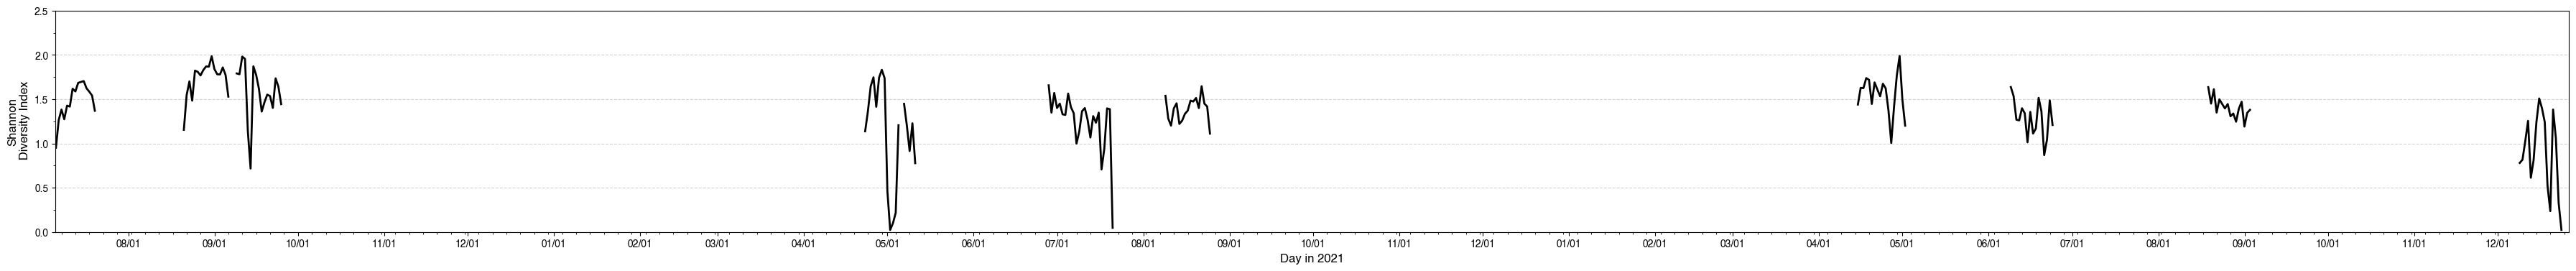

In [78]:
plt.rcParams["font.family"] = "Helvetica"

t1 = to_datetime(df_datetime['Datetime'].values[0])
t2 = to_datetime(df_datetime['Datetime'].values[-1])
delta = t2-t1
days = delta.days
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(days/20, 4))

plt.grid(axis='y', ls='--', color='lightgrey')

plt.plot(df_H['Time'], df_H['H'], 'k' ,lw=2)
last_index = df_H['H'][df_H['H'].isna() == False].index[-1]
# plt.xlim(df_H['Time'][0], df_H['Time'][last_index])
# plt.xlim(datetime(2023,6,10), datetime(2023,6,26))
plt.ylabel('Shannon\n Diversity Index', fontsize=12)
plt.ylim(0, 2.5)
plt.xlim(t1, t2)

plt.xlabel(f'Day in {year}', fontsize=12)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

# plt.savefig('qqq.png', dpi=150)
df_H.to_csv(f'{savepath}/{place}_{year}_index_variations.csv', index=False)
plt.savefig(f'{savepath}/{place}_{year}_index_variations.png', dpi=150, bbox_inches='tight' )
plt.savefig(f'{savepath}/{place}_{year}_index_variations.pdf', dpi=150, bbox_inches='tight' )

In [79]:
def stats_plot(data, index, ax, year=2021, savepath=None):
    Q1 = round(np.nanpercentile(data, 25, interpolation = 'midpoint'), 3)
    Q2 = round(np.nanmedian(data),3)
    Q3 = round(np.nanpercentile(data, 75, interpolation = 'midpoint'), 3)
    pct5 = round(np.nanpercentile(data, 5, interpolation = 'midpoint'),3)
    pct95 = round(np.nanpercentile(data, 95, interpolation = 'midpoint'),3)
    mean = np.nanmean(data)
    std = np.nanstd(data)
    print(pct5, Q1, Q2, mean, Q3, pct95)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    
    upper_idx = data>=upper_bound
    lower_idx = data<=lower_bound

    
    ax.plot([index, index], [pct5, pct95], lw=2, color='r')
    ax.plot([index, index], [Q1, Q3], lw=7, color='r')
    ax.plot([index], [Q2], marker='o', markersize = 7, color='white', mec='k', mew=1.5)# ,edgecolors='k', lw=2
    ax.text(index+0.05, Q2, float("{:.2f}".format(Q2,2)), ha='left', va ='top', fontsize=8)
    
    # if not drop_num[0] is np.nan:
        # ax.scatter([index]*len(drop_num), drop_num,  marker='o', s=5, color='white', edgecolors='r', lw=2, alpha=0.2)
    # print(index, mean, Q2, std, np.nanmin(data), np.nanmax(data))
    # print(index, pct5,Q1, Q2, Q3, pct95, drop_num, np.nanmin(data), np.nanmax(data))
    
    if not os.path.isfile(f'{savepath}/stats.log'):
        minn = np.nanmin(data)
        maxx = np.nanmax(data)
        cmd = ''' 
        echo year,index,pct5,Q1,Q2,Q3,pct95,min,max,mean,std > %(savepath)s/stats.log
        echo %(year)i,%(index)i,%(pct5)f,%(Q1)f,%(Q2)f,%(Q3)f,%(pct95)f,%(minn)f,%(maxx)f,%(mean)f,%(std)f >> %(savepath)s/stats.log
        '''%locals()
    else:
        minn = np.nanmin(data)
        maxx = np.nanmax(data)
        cmd = ''' 
        echo %(year)i,%(index)i,%(pct5)f,%(Q1)f,%(Q2)f,%(Q3)f,%(pct95)f,%(minn)f,%(maxx)f,%(mean)f,%(std)f >> %(savepath)s/stats.log
        '''%locals()        
    os.system(cmd)
    print()
    return Q1, Q2, Q3, ax

1.107 1.376 1.54 1.4744218483944627 1.62 1.699

1.318 1.701 1.781 1.7286933451632573 1.839 1.927

0.931 1.444 1.617 1.5742157833507504 1.781 1.967

0.061 0.845 1.216 1.1216950837329918 1.546 1.789

0.822 1.184 1.345 1.2492714441478971 1.4 1.567

1.156 1.281 1.399 1.3846763619643443 1.473 1.592

1.102 1.442 1.615 1.553296817177796 1.681 1.878

0.941 1.14 1.305 1.2854923886054004 1.442 1.585

1.218 1.341 1.394 1.4059581894294477 1.46 1.624

0.023 0.518 0.817 0.8387783980380413 1.241 1.453



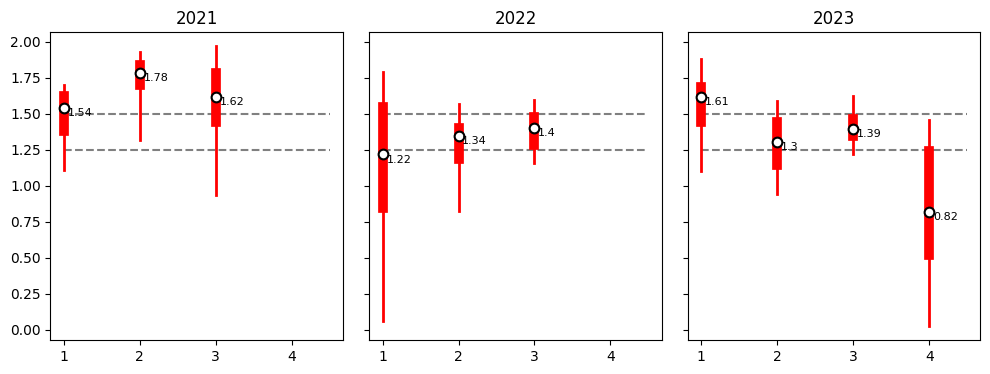

In [80]:
dp = pd.read_csv('../Results/soundsepration/experiment_period.txt')
dp = dp[dp['region']==place]

plt.rcParams["font.family"] = "DejaVu Sans"
fig, ax = plt.subplots(1,3,figsize=(12,4), sharey=True)
plt.subplots_adjust(wspace = 0.09) 

for year in [2021, 2022, 2023]:
    dp_year = dp[dp['year']==year]
    if year == 2021:
        pidx = 0 
    elif year == 2022:
        pidx = 1
    elif year == 2023:
        pidx = 2  
    ax[pidx].set_title(f'{year}')
    ax[pidx].hlines(y=1.5,xmin=1, xmax=4.5, ls='--', color='grey')
    ax[pidx].hlines(y=1.25,xmin=1, xmax=4.5, ls='--', color='grey')
    for exp in set(dp_year['index']):
        dp_index = dp_year[dp_year['index']==exp]
        begin = dp_index['begin'].values[0]
        end = dp_index['end'].values[0]
        begintime = datetime.strptime(begin, "%Y-%m-%dT%H:%M:%S")
        endtime = datetime.strptime(end, "%Y-%m-%dT%H:%M:%S")
        stage = df_H[df_H['Time']<=endtime+timedelta(days=1)][df_H['Time']>=begintime-timedelta(days=1)]
        Q1, Q2, Q3, ax[pidx] = stats_plot(stage['H'], exp, ax[pidx], year=year, savepath='./qqq/result_normalized_each_stage')
plt.savefig(f'{savepath}/{place}_index_stats.png', dpi=150 )
plt.savefig(f'{savepath}/{place}_index_stats.pdf', dpi=150 )